In [2]:
# import all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import os
import warnings
import spacy

from textblob import TextBlob
from IPython.display import display, HTML, Markdown

from sklearn.feature_extraction.text import CountVectorizer

import string
import nltk
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

from wordcloud import WordCloud
from collections import Counter

warnings.filterwarnings('ignore') # remove the warnings

In [1]:
def load_txt_file(website, Nb_files):
    if website == 'BeerAdvocate':
        # Specify the directory containing the text files 
        # Need to be outside of the repo folder and might need to change the path according to one's unique folders configuration
        directory = './../../dataset_BeerReviews/BeerAdvocate/ratings_split_BA/'
    elif website == 'RateBeer':
        directory = './../../dataset_BeerReviews/RateBeer/ratings_split_RB/'

    # Initialize an empty list to store DataFrames
    dfs = []

    # Loop through the files in reverse order (ratings-5.txt to ratings-1.txt)
    for i in range(Nb_files, 0, -1):
        file_name = f'ratings-{i}.txt'
        file_path = os.path.join(directory, file_name)

        with open(file_path, 'r') as f:
            text = f.read()

        # Remove double quotes at the beginning of each line
        data = re.sub('"', '', text)
        data = re.sub(r'^"', '', data, flags=re.MULTILINE)

        # Split the text into individual beer reviews
        beer_reviews = data.split('beer_name')

        # Extract the beer information from each review
        beer_data = []
        for review in beer_reviews:
            beer_info = {}
            for line in [entry.split(':', 1) for entry in review.split('\n') if ':' in entry]:# and 'text' not in entry]:
                if line:  # Check if the list is not empty
                    key, value = line[0].strip(), line[1].strip()
                    beer_info[key] = value
            beer_data.append(beer_info)

        # Convert the beer data into a DataFrame
        df = pd.DataFrame(beer_data)

        # Append the DataFrame to the list
        dfs.append(df)

    # Concatenate all DataFrames into a single DataFrame
    final_df = pd.concat(dfs, ignore_index=True)

    # Rename the columns depending on the website
    if website == 'BeerAdvocate':
        final_df.columns = [
            'beer_name',
            'beer_id',
            'brewery_name',
            'brewery_id',
            'style',
            'abv',
            'date',
            'user_name',
            'user_id',
            'appearance',
            'aroma',
            'palate',
            'taste',
            'overall',
            'rating',
            'text',
            'review'] # additional column compared to RB
    else:
        final_df.columns = [
            'beer_name',
            'beer_id',
            'brewery_name',
            'brewery_id',
            'style',
            'abv',
            'date',
            'user_name',
            'user_id',
            'appearance',
            'aroma',
            'palate',
            'taste',
            'overall',
            'rating',
            'text']
    return final_df

def sample_data(df, ratio):
    # sample the data to make it even smaller
    return df.sample(frac = ratio, random_state=42)

In [3]:
# Load data : for faster processing, we will only load 1 file out of the whole dataset
ratings_BA = load_txt_file('BeerAdvocate', 1)
ratings_RB = load_txt_file('RateBeer', 1)

In [4]:
# Sample data to make it even smaller AND RANDOMIZED (not randomized in the initial txt splitting process)
ratings_BA = sample_data(df = ratings_BA, ratio = 0.25)
ratings_RB = sample_data(df = ratings_RB, ratio = 0.25)

In [5]:
# BeerAdvocate
beers_BA = pd.read_csv("./dataset_BeerReviews/BeerAdvocate/beers.csv")
breweries_BA = pd.read_csv("./dataset_BeerReviews/BeerAdvocate/breweries.csv")
users_BA = pd.read_csv("./dataset_BeerReviews/BeerAdvocate/users.csv")

# RateBeer
beers_RB = pd.read_csv("./dataset_BeerReviews/RateBeer/beers.csv")
breweries_RB = pd.read_csv("./dataset_BeerReviews/RateBeer/breweries.csv")
users_RB = pd.read_csv("./dataset_BeerReviews/RateBeer/users.csv")

# matched_beer_data
beers_matched = pd.read_csv("./dataset_BeerReviews/matched_beer_data/beers.csv", header=1)
breweries_matched = pd.read_csv("./dataset_BeerReviews/matched_beer_data/breweries.csv", header = 1)
ratings_matched = pd.read_csv("./dataset_BeerReviews/matched_beer_data/ratings.csv", header=1)
users_approx = pd.read_csv("./dataset_BeerReviews/matched_beer_data/users_approx.csv", header=1)
users_matched = pd.read_csv("./dataset_BeerReviews/matched_beer_data/users.csv", header=1)

In [6]:
# Get types of features in each DataFrame
df_types = pd.concat([df.dtypes.rename(f"DataFrame {i+1}") for i, df in enumerate([ratings_BA, ratings_RB])], axis=1)
df_types

,DataFrame 1,DataFrame 2
beer_name,object,object
beer_id,object,object
brewery_name,object,object
brewery_id,object,object
style,object,object
abv,object,object
date,object,object
user_name,object,object
user_id,object,object
appearance,object,object


In [7]:
def convert_type(df, col):
    error_rows = []
    try:
        df[col] = pd.to_numeric(df[col], errors='raise').astype('float64')
    except (ValueError, TypeError) as e:
        print(f"Could not convert {col} to float64 in the DataFrame.")
        error_rows = df.loc[df[col].apply(lambda x: not pd.to_numeric(x, errors='coerce')).notna()]

    return df, error_rows

# Columns including the numerical features for both websites
# 'user_id' is numerical in RB but categorical in BA, so we don't include it
numerical_cols = ['beer_id', 'abv', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']

for col in numerical_cols:
    ratings_BA, error_rows_BA = convert_type(ratings_BA, col)
    ratings_RB, error_rows_RB = convert_type(ratings_RB, col)

    #if not error_rows_BA.empty:
    #    print(f"Errors in ratings_BA for column {col} at rows:\n{error_rows_BA}")

    #if not error_rows_RB.empty:
    #    print(f"Errors in ratings_RB for column {col} at rows:\n{error_rows_RB}")


Could not convert abv to float64 in the DataFrame.
Could not convert abv to float64 in the DataFrame.
Could not convert appearance to float64 in the DataFrame.
Could not convert aroma to float64 in the DataFrame.
Could not convert palate to float64 in the DataFrame.
Could not convert taste to float64 in the DataFrame.
Could not convert overall to float64 in the DataFrame.


In [ ]:
ratings_BA[ratings_BA.index==100743]

In [8]:
# Get types of features in each DataFrame
df_types = pd.concat([df.dtypes.rename(f"DataFrame {i+1}") for i, df in enumerate([ratings_BA, ratings_RB])], axis=1)
df_types

,DataFrame 1,DataFrame 2
beer_name,object,object
beer_id,float64,float64
brewery_name,object,object
brewery_id,object,object
style,object,object
abv,object,object
date,object,object
user_name,object,object
user_id,object,object
appearance,object,float64


In [ ]:
nltk.download('words')
nltk.download('stopwords') # Download NLTK stopwords
nltk.download('wordnet')   # Lemmatization
nltk.download('words')
english_words=set(words.words())
# Get the set of English stop words
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [17]:

from translate import Translator
import string
import spacy
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

# Load spaCy model for lemmatization
nlp = spacy.load("en_core_web_sm")

# Load NLTK stopwords
stop_words = set(stopwords.words('english'))

def preprocess_sentences(df):
    # Remove rows with no sentences (NaN values or empty sentences)
    df = df.dropna(subset=['text'])
    df = df[df['text'].str.strip().astype(bool)]
    df = df[df['text'] != 'nan']
#
    #def translate_to_english(sentence):
    #    translator = Translator(to_lang="en")
    #    translation = translator.translate(sentence)
    #    return translation
#
    #def clean_text(sentence):
    #    translator = str.maketrans('', '', string.punctuation)
    #    cleaned = sentence.translate(translator).lower()
    #    return cleaned
#
    #def lemmatize_text(sentence):
    #    doc = nlp(sentence)
    #    lemmatized_tokens = [token.lemma_ for token in doc]
    #    return ' '.join(lemmatized_tokens)
#
    #def remove_stopwords(sentence):
    #    tokens = word_tokenize(sentence)
    #    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    #    return ' '.join(filtered_tokens)
#
    #def keep_only_english(sentence):
    #    # Make sure to define english_words before using this function
    #    return " ".join(w for w in nltk.wordpunct_tokenize(sentence) if w.lower() in english_words or not w.isalpha())
#
    ## Apply translation
    #df['translated_text'] = df['text'].apply(translate_to_english)
#
    ## Apply preprocessing steps on the translated text
    #df['cleaned_text'] = df['translated_text'].apply(clean_text)
    #df['cleaned_text'] = df['cleaned_text'].apply(lemmatize_text)
    #df['cleaned_text'] = df['cleaned_text'].apply(remove_stopwords)
    #df['cleaned_text'] = df['cleaned_text'].apply(keep_only_english)  # Uncomment if english_words is defined
#
    return df


In [18]:
# can take 6-8 min to run on all the sentences
ratings_BA_cleaned = preprocess_sentences(ratings_BA)
ratings_RB_cleaned = preprocess_sentences(ratings_RB)

In [19]:
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return analyzer.polarity_scores(text)

In [27]:
# can take 6-8 min to run on all the sentences

# with original text
ratings_BA_cleaned['polarity_text'] = ratings_BA_cleaned['text'].apply(lambda x: getPolarity(x))
ratings_BA_cleaned['polarity_rating'] = ratings_BA_cleaned['text'].apply(lambda x: getPolarity(x)['compound'])
ratings_BA_cleaned['subjectivity_text'] = ratings_BA_cleaned['text'].apply(lambda x: getSubjectivity(x))


In [28]:
ratings_BA_cleaned.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review,polarity_text,subjectivity_text,polarity_rating
273843,Solstice D'été Aux Cerises,73716.0,Brasserie Dieu du Ciel!,1141,Berliner Weissbier,6.5,1444644000,hopsolutely,hopsolutely.513175,4.0,4.0,3.5,4.0,3.75,3.90,Enjoying with thanks to Phyl21ca.Rarely does a...,True,"{'neg': 0.038, 'neu': 0.704, 'pos': 0.258, 'co...",0.487500,0.9042
169417,O'Hanlons Organic Rye,9123.0,O'Hanlon Brewing Co. Ltd.,1533,Rye Beer,5.0,1214733600,aerozeppl,aerozeppl.101084,3.0,3.0,4.0,3.0,3.0,3.10,A: 2 Finger pour. White head with some piting....,True,"{'neg': 0.081, 'neu': 0.863, 'pos': 0.056, 'co...",0.385152,-0.3037
90288,Samuel Smith's Pure Brewed Organic Lager Beer,778.0,Samuel Smith Old Brewery (Tadcaster),113,Euro Pale Lager,5.0,1160560800,jasonjlewis,jasonjlewis.74038,4.0,4.5,4.0,4.0,4.0,4.12,This beer is really a no frills beer to relax ...,True,"{'neg': 0.051, 'neu': 0.697, 'pos': 0.252, 'co...",0.630571,0.9771
434380,Mill Street Father John's Ale,68193.0,Mill Street Brew Pub,3760,Extra Special / Strong Bitter (ESB),6.3,1303034400,Sammy,sammy.3853,4.0,3.5,2.5,2.5,3.0,2.93,Poor for style. On tap at Gambrinus. Orange co...,True,"{'neg': 0.377, 'neu': 0.623, 'pos': 0.0, 'comp...",0.600694,-0.9711
165244,Hobgoblin,236.0,Wychwood Brewery Company Ltd,160,Extra Special / Strong Bitter (ESB),5.2,1276077600,MarvinSnyder,marvinsnyder.274163,4.5,4.5,4.0,4.0,4.0,4.15,6-9-10 - poured into a Samuel Smith pint glass...,True,"{'neg': 0.052, 'neu': 0.775, 'pos': 0.174, 'co...",0.512500,0.9516


In [29]:
# can take 8-10 min to run on all the sentences
# can take 6-8 min to run on all the sentences

# with original text
ratings_RB_cleaned['polarity_text'] = ratings_RB_cleaned['text'].apply(lambda x: getPolarity(x))
ratings_RB_cleaned['polarity_rating'] = ratings_RB_cleaned['text'].apply(lambda x: getPolarity(x)['compound'])
ratings_RB_cleaned['subjectivity_text'] = ratings_RB_cleaned['text'].apply(lambda x: getSubjectivity(x))


In [30]:
ratings_BA_bis = ratings_BA_cleaned.copy()
ratings_RB_bis= ratings_RB_cleaned.copy()
#ratings_RB_bis['adapted_polarity_cleaned_text'] = (ratings_RB_cleaned['polarity_cleaned_text']+1)*5/2
#ratings_BA_bis['adapted_polarity_cleaned_text'] = (ratings_BA_cleaned['polarity_cleaned_text']+1)*5/2
#ratings_RB_bis['overall'] = ratings_RB['overall']*5/20

In [31]:
ratings_BA_bis.dtypes

beer_name             object
beer_id              float64
brewery_name          object
brewery_id            object
style                 object
abv                   object
date                  object
user_name             object
user_id               object
appearance            object
aroma                 object
palate                object
taste                 object
overall               object
rating               float64
text                  object
review                object
polarity_text         object
subjectivity_text    float64
polarity_rating      float64
dtype: object

In [32]:
ratings_BA_bis['polarity_rating'].describe()

count    49074.000000
mean         0.691827
std          0.438993
min         -0.998500
25%          0.636900
50%          0.891000
75%          0.962900
max          0.999600
Name: polarity_rating, dtype: float64

In [33]:
ratings_RB_bis['polarity_rating'].describe()

count    111692.000000
mean          0.397793
std           0.494821
min          -0.994500
25%           0.000000
50%           0.526700
75%           0.829825
max           0.999100
Name: polarity_rating, dtype: float64

In [49]:
ratings_RB_bis['stand_polarity']= ratings_RB_bis['polarity_rating'].apply(lambda x: (x-ratings_RB_bis['polarity_rating'].mean())/ratings_RB_bis['polarity_rating'].std())
ratings_BA_bis['stand_polarity']= ratings_BA_bis['polarity_rating'].apply(lambda x: (x-ratings_BA_bis['polarity_rating'].mean())/ratings_BA_bis['polarity_rating'].std())


In [50]:
ratings_BA['stand_rating']= ratings_BA['rating'].apply(lambda x: (x-ratings_BA['rating'].mean())/ratings_BA['rating'].std())
ratings_RB['stand_rating']= ratings_RB['rating'].apply(lambda x: (x-ratings_RB['rating'].mean())/ratings_RB['rating'].std())

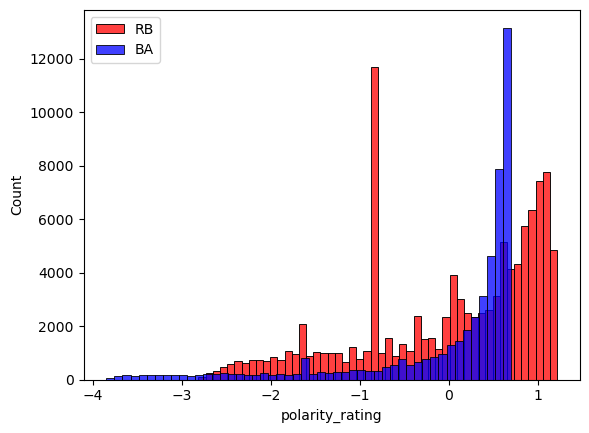

In [43]:
sns.histplot(ratings_RB_bis_stand, bins=50, label='RB', color='red')
sns.histplot(ratings_BA_bis_stand, bins=50, label='BA', color='blue')
plt.legend()

In [79]:
ratings_BA["new_rating"] = (ratings_BA['stand_rating'] + ratings_BA_bis['stand_polarity']) * (1 - ratings_BA_bis['subjectivity_text'])
ratings_RB["new_rating"] = (ratings_RB['stand_rating'] + ratings_RB_bis['stand_polarity']) * (1 - ratings_RB_bis['subjectivity_text'])
ratings_BA["new_rating_no_std"] = (ratings_BA['stand_rating'] + ratings_BA_bis['polarity_rating']) * (1 - ratings_BA_bis['subjectivity_text'])
ratings_RB["new_rating_no_std"] = (ratings_RB['stand_rating'] + ratings_RB_bis['polarity_rating']) * (1 - ratings_RB_bis['subjectivity_text'])


In [58]:
new_ranking_beer_BA = ratings_BA.groupby('beer_id')['new_rating'].mean().sort_values(ascending=False)
new_ranking_beer_BA.head(20)

beer_id
90755.0     1.369986
111331.0    1.296786
252801.0    1.274377
278649.0    1.225374
52410.0     1.207690
38371.0     1.198143
36154.0     1.192069
123885.0    1.148479
64070.0     1.141170
113747.0    1.139877
15928.0     1.122670
164776.0    1.121553
34223.0     1.120614
68187.0     1.111554
78541.0     1.107125
282803.0    1.096265
280201.0    1.079101
266245.0    1.072476
80824.0     1.069743
61022.0     1.066148
Name: new_rating, dtype: float64

In [69]:
ranking_beer_BA = ratings_BA.groupby('beer_id')['stand_rating'].mean().sort_values(ascending=False)
ranking_beer_BA.head(20)

beer_id
226708.0    1.919887
65754.0     1.919887
189489.0    1.919887
110680.0    1.919887
280201.0    1.919887
87712.0     1.919887
12197.0     1.919887
135968.0    1.919887
12493.0     1.919887
200223.0    1.919887
250325.0    1.919887
85081.0     1.919887
234220.0    1.919887
164776.0    1.919887
287477.0    1.919887
102155.0    1.919887
58698.0     1.919887
135909.0    1.919887
195435.0    1.832895
68187.0     1.803898
Name: stand_rating, dtype: float64

In [59]:
new_ranking_beer_RB = ratings_RB.groupby('beer_id')['new_rating'].mean().sort_values(ascending=False)
new_ranking_beer_RB.head(20)

beer_id
7252.0      2.027027
417509.0    1.965100
519115.0    1.890203
533265.0    1.853920
401930.0    1.829649
279829.0    1.763996
520226.0    1.761716
140890.0    1.696782
455491.0    1.670197
395993.0    1.640159
267178.0    1.601152
312250.0    1.600434
522569.0    1.599138
307202.0    1.556654
458460.0    1.521742
372392.0    1.515598
451577.0    1.512845
336287.0    1.501907
488109.0    1.486474
178202.0    1.471822
Name: new_rating, dtype: float64

In [70]:
ranking_beer_RB = ratings_RB.groupby('beer_id')['stand_rating'].mean().sort_values(ascending=False)
ranking_beer_RB.head(20)

beer_id
522569.0    2.398408
417509.0    2.398408
398091.0    2.398408
401930.0    2.398408
374007.0    2.398408
432595.0    2.398408
395993.0    2.398408
525943.0    2.398408
234296.0    2.398408
529029.0    2.272494
336287.0    2.272494
153737.0    2.272494
409969.0    2.146579
7252.0      2.083622
140890.0    2.020665
339263.0    2.020665
123707.0    2.020665
394722.0    2.020665
490668.0    2.020665
413502.0    2.020665
Name: stand_rating, dtype: float64

In [71]:
ranking_brewery_BA = ratings_BA.groupby('brewery_name')['stand_rating'].mean().sort_values(ascending=False)
ranking_brewery_BA.head(20)

brewery_name
Barum Brewery Limited                       1.629916
Hornbeam Brewery                            1.557424
Ealing Park Tavern / Long Arm Brewing       1.325448
GLV Brewing Company                         1.310949
Cerveza Dos Palomas                         1.194961
Hadrian & Border Brewery                    1.194961
Little Beer Coporation                      1.194961
Toast Ale                                   1.165964
Microbrasserie de Bellechasse               1.136967
Barefoot Brewing Company (Jungle Beer)      1.122469
Sherwood Mountain                           1.107970
Cervecería Fausto                           1.078973
The Bull Restaurant / London Brewing Co.    1.035478
Pictish Brewing Company                     1.020979
Savour Beer                                 1.020979
Whitetooth Brewing Company                  1.013730
Runaway Brewery                             1.006481
Hewitt's Brewery                            0.948486
Deya Brewing Company             

In [72]:
new_ranking_brewery_BA = ratings_BA.groupby('brewery_name')['new_rating'].mean().sort_values(ascending=False)
new_ranking_brewery_BA.head(20)

brewery_name
Barum Brewery Limited                    1.122670
Brimstage Brewing Co Ltd                 1.120614
Moulin Hotel & Brewery                   1.008275
Dartmoor Brewery                         0.998877
GLV Brewing Company                      0.982914
Pictish Brewing Company                  0.815177
Kirkby Lonsdale Brewery Co Ltd           0.803571
Propaganda Brewing                       0.789657
Paulaner Brauhaus (Pulana Pijiu Fang)    0.774868
North Riding Brew Pub                    0.762126
Runaway Brewery                          0.748975
Howling Hops                             0.748616
Prairie Sun Brewery                      0.731059
Wilson Potter Brewery                    0.728419
Sherwood Mountain                        0.715304
Wincle Beer Company Limited              0.702052
Why Not Brewery, The                     0.696761
Howard Town Brewery                      0.676421
Red Lion Ales                            0.673307
Kazbegi-Castel Lilo Brewery          

In [73]:
ranking_brewery_RB = ratings_RB.groupby('brewery_name')['stand_rating'].mean().sort_values(ascending=False)
ranking_brewery_RB.head(20)

brewery_name
Heritage Brewing Company &#40;NS&#41;    2.398408
Bore City Brewing                        2.398408
Casa Cervecera Lucas                     1.768836
ibenska Pivovara                        1.768836
Cuarto Vacío Brewing Co.                 1.768836
Rossland Beer Company                    1.642922
Cerveceria Imperial                      1.642922
Gin Ale                                  1.642922
Microcerveceria La Legendaria            1.579964
Save The Ales                            1.391093
Kowloon Bay Brewery                      1.328136
Graystone Brewing                        1.265178
Pitomačka pivovara                       1.265178
Neill & Ross                             1.208517
Brasserie Auval Brewing Co.              1.197615
Superflux &#40;Machine Ales&#41;         1.181235
LoveShack Libations                      1.139264
Villa Castanea                           1.013350
Cerveza Arteza                           1.013350
Tshinvalskiy Pivovarenniy Zavod      

In [74]:
new_ranking_brewery_RB = ratings_RB.groupby('brewery_name')['new_rating'].mean().sort_values(ascending=False)
new_ranking_brewery_RB.head(20)

brewery_name
Bore City Brewing                        1.965100
Bosiger                                  1.600434
Kowloon Bay Brewery                      1.260447
Superflux &#40;Machine Ales&#41;         1.098351
Rye & Pint                               1.031552
Danforth Brewery                         0.988546
Rodbrau / Pinta-Haus                     0.981538
LoveShack Libations                      0.968849
Cuarto Vacío Brewing Co.                 0.943506
Bavarska Pivovara Jastrebarsko           0.922524
Villa Castanea                           0.886993
Microcerveceria La Legendaria            0.859503
Heritage Brewing Company &#40;NS&#41;    0.846976
Vergal Beer                              0.823034
Cervecería Alebrije                      0.816996
Neill & Ross                             0.790783
Nonsuch Brewing Company                  0.769428
Murdoch Brewing                          0.760739
4 Degrees Brewing                        0.756611
Red Cat Brewery                      

In [80]:
new_ranking_no_std_brewery_RB = ratings_RB.groupby('brewery_name')['new_rating_no_std'].mean().sort_values(ascending=False)
new_ranking_no_std_brewery_RB.head(20)

brewery_name
Bore City Brewing                        1.921930
Bosiger                                  1.638035
Kowloon Bay Brewery                      1.217294
Cuarto Vacío Brewing Co.                 1.168512
Microcerveceria La Legendaria            1.126897
Cerveza Arteza                           1.065434
Superflux &#40;Machine Ales&#41;         1.053750
Tshinvalskiy Pivovarenniy Zavod          1.013350
Heritage Brewing Company &#40;NS&#41;    1.000281
Zadarska Pivovara                        0.983964
Rodbrau / Pinta-Haus                     0.983441
Neill & Ross                             0.943874
Rye & Pint                               0.937101
Vergal Beer                              0.924846
LoveShack Libations                      0.920972
Gin Ale                                  0.895402
Mykulychyn                               0.887435
Danforth Brewery                         0.881427
Brasserie Auval Brewing Co.              0.870586
Cerveza Juguete                      